In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import random
import seaborn as sns
import itertools as it

from metric_voting.spatial_generation import Spatial, GroupSpatial
from metric_voting.elections import *
from metric_voting.measurements import *
from metric_voting.utils import *
from metric_voting.election_sampling import election_sample, samples
from metric_voting.plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
# Colors for plotting!
#pal = sns.color_palette("hls", 8)
#tab20_colors = plt.cm.tab20b.colors
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]

colors2 = colors = colors[:6] + colors[-12::2]

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

# Group Representation

This notebook is designed to give some insight into how we ran our experiments and generated figures for them. The code for more computationally intensive experiments can be found in `experiments/` or computed with the code from `election_sampling.py`

In [4]:
# Choose number of voters n and the number of candidates m
n = 100
m = 20

# Choose the number of winners for the election
k = 4

### Elections

Now, with our random spatial generators we'd like to be able to collect a bunch of samples where we 
1. Randomly generate voter and candidate positions
2. Run a set of election mechanisms on the ranked preference profile from that randomly generated setting
3. Record the results

Most of the heavy lifting for this process is done with `election_sampling.py`, but we show examples 
for how to interface with that here. 

NOTE: For deterministic results, set the seed with `np.random.seed(...)` (we use 918717)

In [8]:
# Define a dictionary of elections with input parameters given 
# (really only need it for DMRD but its implemented this way for completeness) :)
elections_dict = {SNTV:{}, Bloc:{}, Borda:{}, STV:{'transfer_type' : 'weighted-fractional'},
                 ChamberlinCourant:{'solver' : 'PULP_CBC_CMD'}, GreedyCC:{},
                  Monroe:{'solver' : 'PULP_CBC_CMD'}, 
                  PluralityVeto:{}, ExpandingApprovals: {},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}}

# List of elections being used
elections_list = [SNTV, Bloc, Borda, STV, ChamberlinCourant, GreedyCC, Monroe, 
                  PluralityVeto, ExpandingApprovals, SMRD, OMRD, DMRD]

# Number of samples to compute with
n_samples = 10

In [24]:
# This shows you how to compute the sampled results and save to memory, 
# since this is a computationally intensive process, we omit running this for now

# Compute election results and save to memory!
np.random.seed(918717)
f = '../data/2bloc_new.npz'
generator_input = [
    {'voter_group_sizes': two_party_G,
     'candidate_group_sizes': [m]}
]

result_list = samples(
    n_samples,
    two_party_generator,
    elections_dict,
    generator_input,
    k,
    dim = 2,
    filename = f
)

result_dict = result_list[0]

In [5]:
# Or load in a set of precomputed results:
# NOTE: There are many examples from our paper which haven't been uploaded 
#       to the repository for space constraints. All files necessary for computing 
#       these datasets are included in the experiments/ folder. 

f = '../data/data/2bloc_new.npz'
loaded_data = np.load(f)
result_dict = {key: loaded_data[key] for key in loaded_data.files}
n_samples = result_dict['voters'].shape[0]

In [6]:
result_dict['SNTV'][0]

array([False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False])

### Distribution Plot

Now we can see what the distribution of results looks like for each election mechanism. 
For each we show a Kernel Density Estimate (KDE) for the distribution of voter and winner positions. 
We also show scatter plots for the aggregation of all voter and candidate positions seen throughout the 
samples, as well as for a single election example.

NOTE: The KDE's will look a bit strange when you plot them here. That's because we're only using a small fraction of the collected samples to compute the KDE in this notebook. You can produce the full KDE with the code in `experiments/`.

IndexError: index 3 is out of bounds for axis 0 with size 3

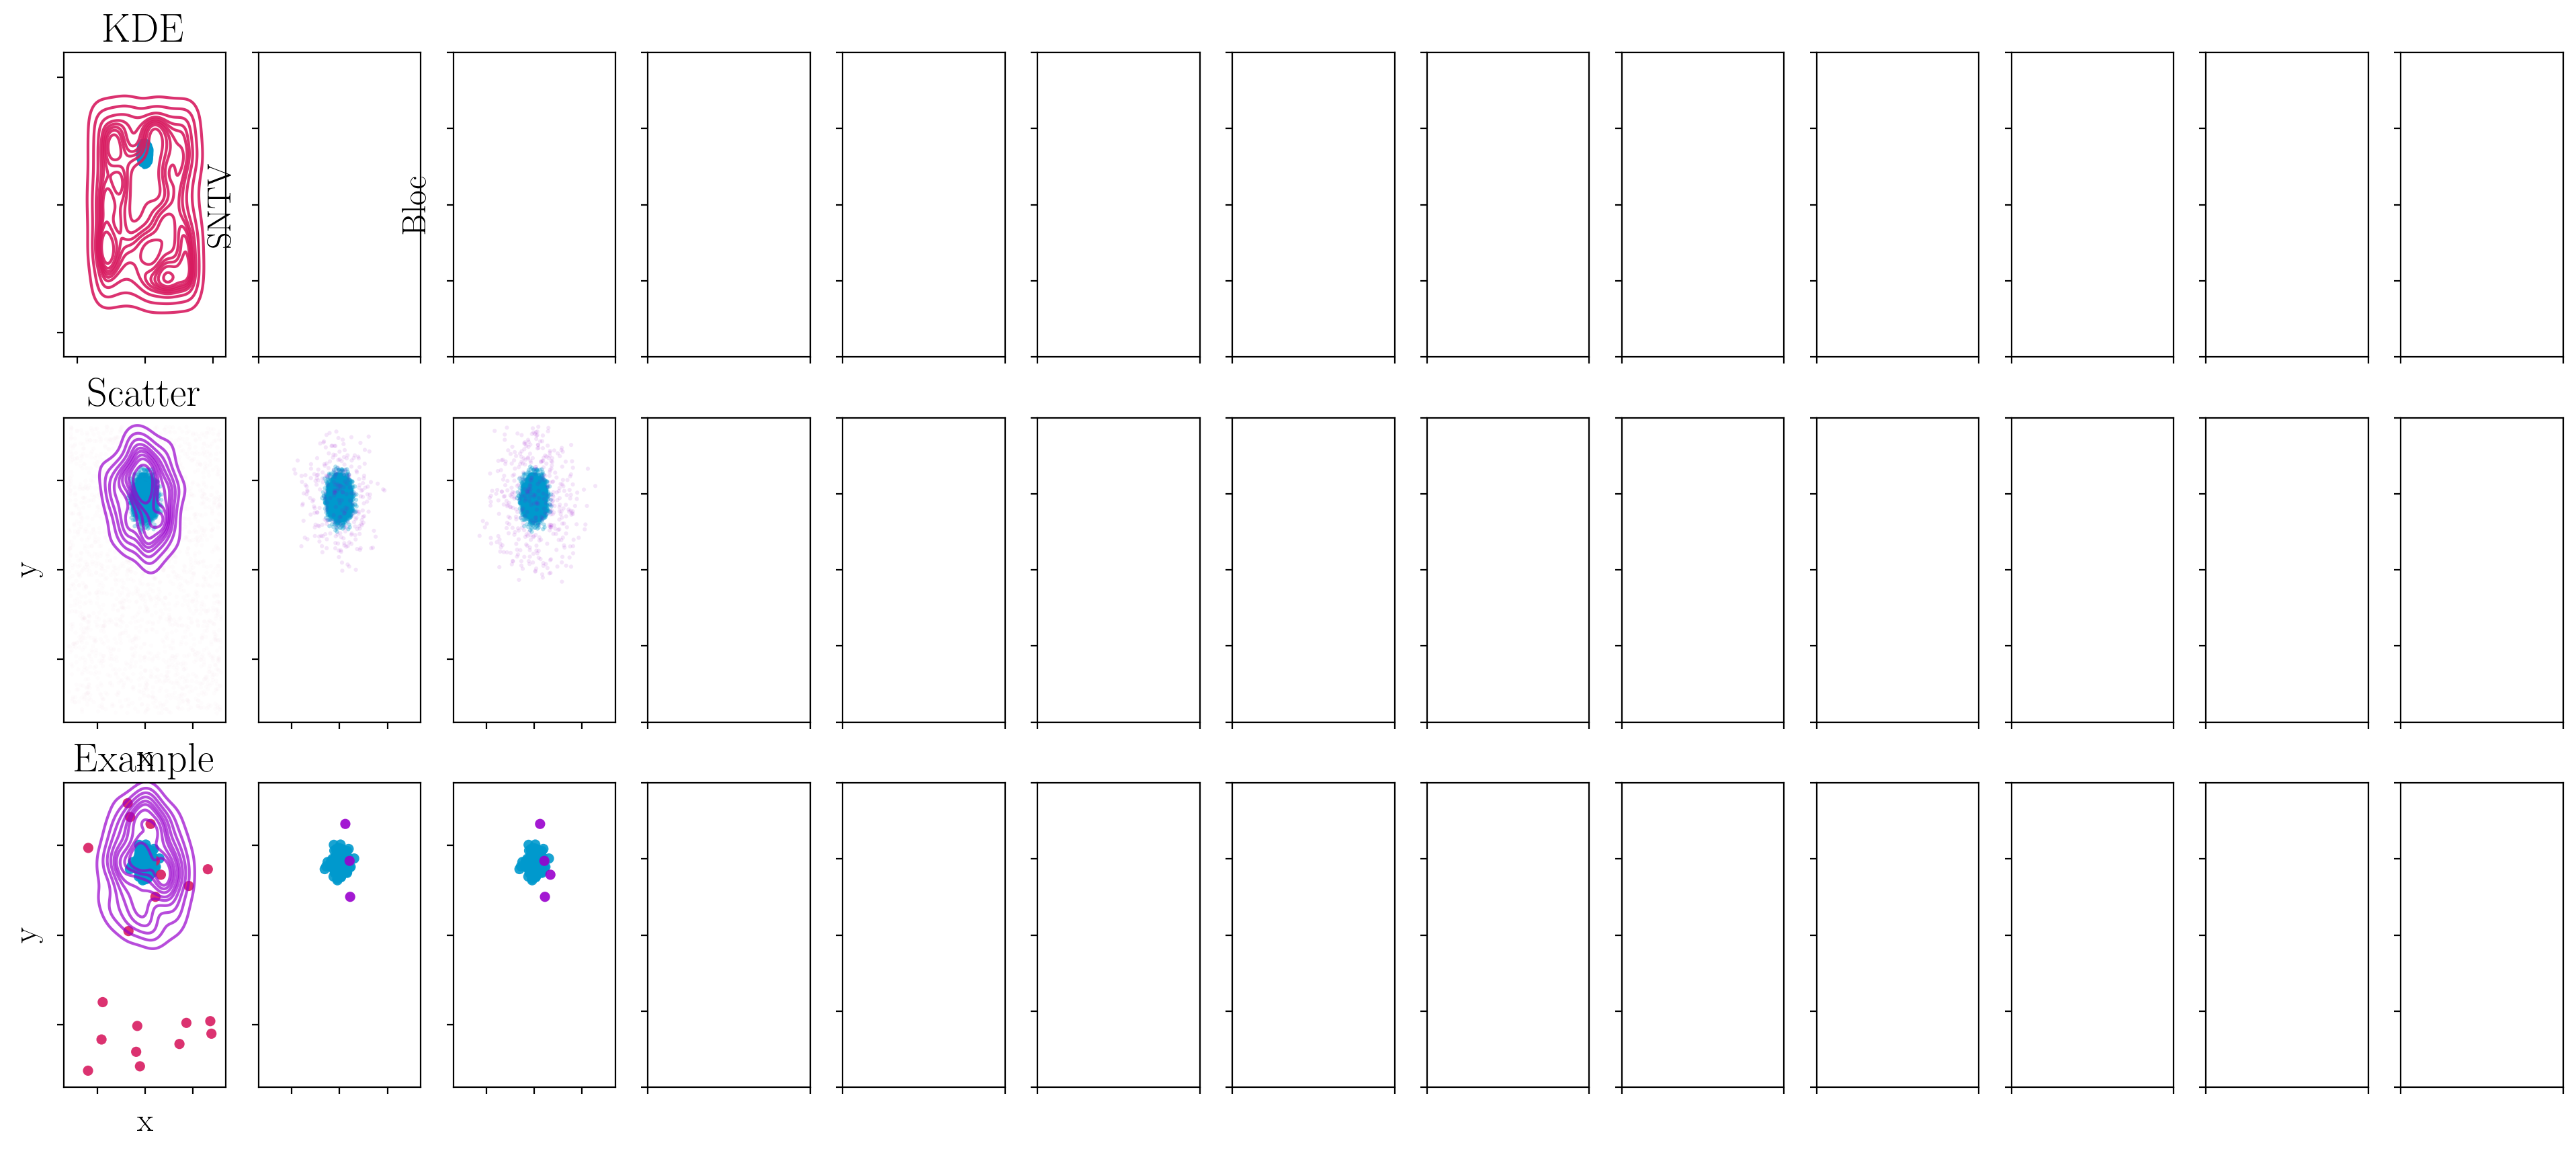

In [63]:
plot_winner_distribution(
    results = result_dict,
    fig_params = {'figsize' : (24, 10), 'dpi' : 200},
    colors = [colors2[0], colors2[-2], colors2[5]],
    sample_fraction = 0.01,
    random_seed = 42,
    output_file = None
)

### Representation Measures

Next we can visualize how the elections perform with respect to our group and overall inefficiency measures. Please see the paper or code in `tools.py` for more details on how these measurements are computed.

In [7]:
n

100

In [8]:
##############################################################################################################
# Compute results:
elections = [_ for _ in result_dict.keys() if _ not in ['voters', 'candidates', 'labels']]

# 1) Using known group labels
group_ineff = {e : np.zeros(n_samples) for e in elections}
# 2) Or instead treat everyone as one group
overall_ineff = {e : np.zeros(n_samples) for e in elections}
# 3) Or for the estimated worst case voter block
worst_ineff = {e : np.zeros(n_samples) for e in elections}

group_select = 0
for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    cst_array = euclidean_cost_array(voter_positions, candidate_positions)
    
    group_labels = result_dict['labels'][i]
    overall_labels = np.zeros(len(group_labels)) 
    
    for j, e in enumerate(elections):
        winner_indices = np.where(result_dict[e][i])[0]
        worst_bloc = heuristic_worst_bloc(cst_array, winner_indices)
        worst_labels = np.zeros(n)
        worst_labels[worst_bloc] = 1
        
        grp_ineff = group_inefficiency(cst_array, winner_indices, group_labels, group_select)
        ovr_ineff = group_inefficiency(cst_array, winner_indices, overall_labels, group_select)
        wrst_ineff = group_inefficiency(cst_array, winner_indices, worst_labels, 1)
        
        group_ineff[e][i] = grp_ineff
        overall_ineff[e][i] = ovr_ineff
        worst_ineff[e][i] = wrst_ineff
        
group_data = np.array([values[~np.isnan(values)] for values in group_ineff.values()])
overall_data = np.array([values[~np.isnan(values)] for values in overall_ineff.values()])
worst_data = np.array([values[~np.isnan(values)] for values in worst_ineff.values()])
labels = ['CC' if e == 'ChamberlinCourant' else e for e in elections]
labels = ['Expanding' if e == 'ExpandingApprovals' else e for e in labels]
##########################################################################################################

KeyboardInterrupt: 

In [19]:
i

459

In [18]:
worst_ineff['SNTV'].shape

(10000,)

In [31]:
group_data = np.array([values[~np.isnan(values)] for values in group_ineff.values()])[:,:400]
overall_data = np.array([values[~np.isnan(values)] for values in overall_ineff.values()])[:,:400]
worst_data = np.array([values[~np.isnan(values)] for values in worst_ineff.values()])[:,:400]
labels = ['CC' if e == 'ChamberlinCourant' else e for e in elections]
labels = ['Expanding' if e == 'ExpandingApprovals' else e for e in labels]

Text(0, 0.5, 'Group-Inefficiency')

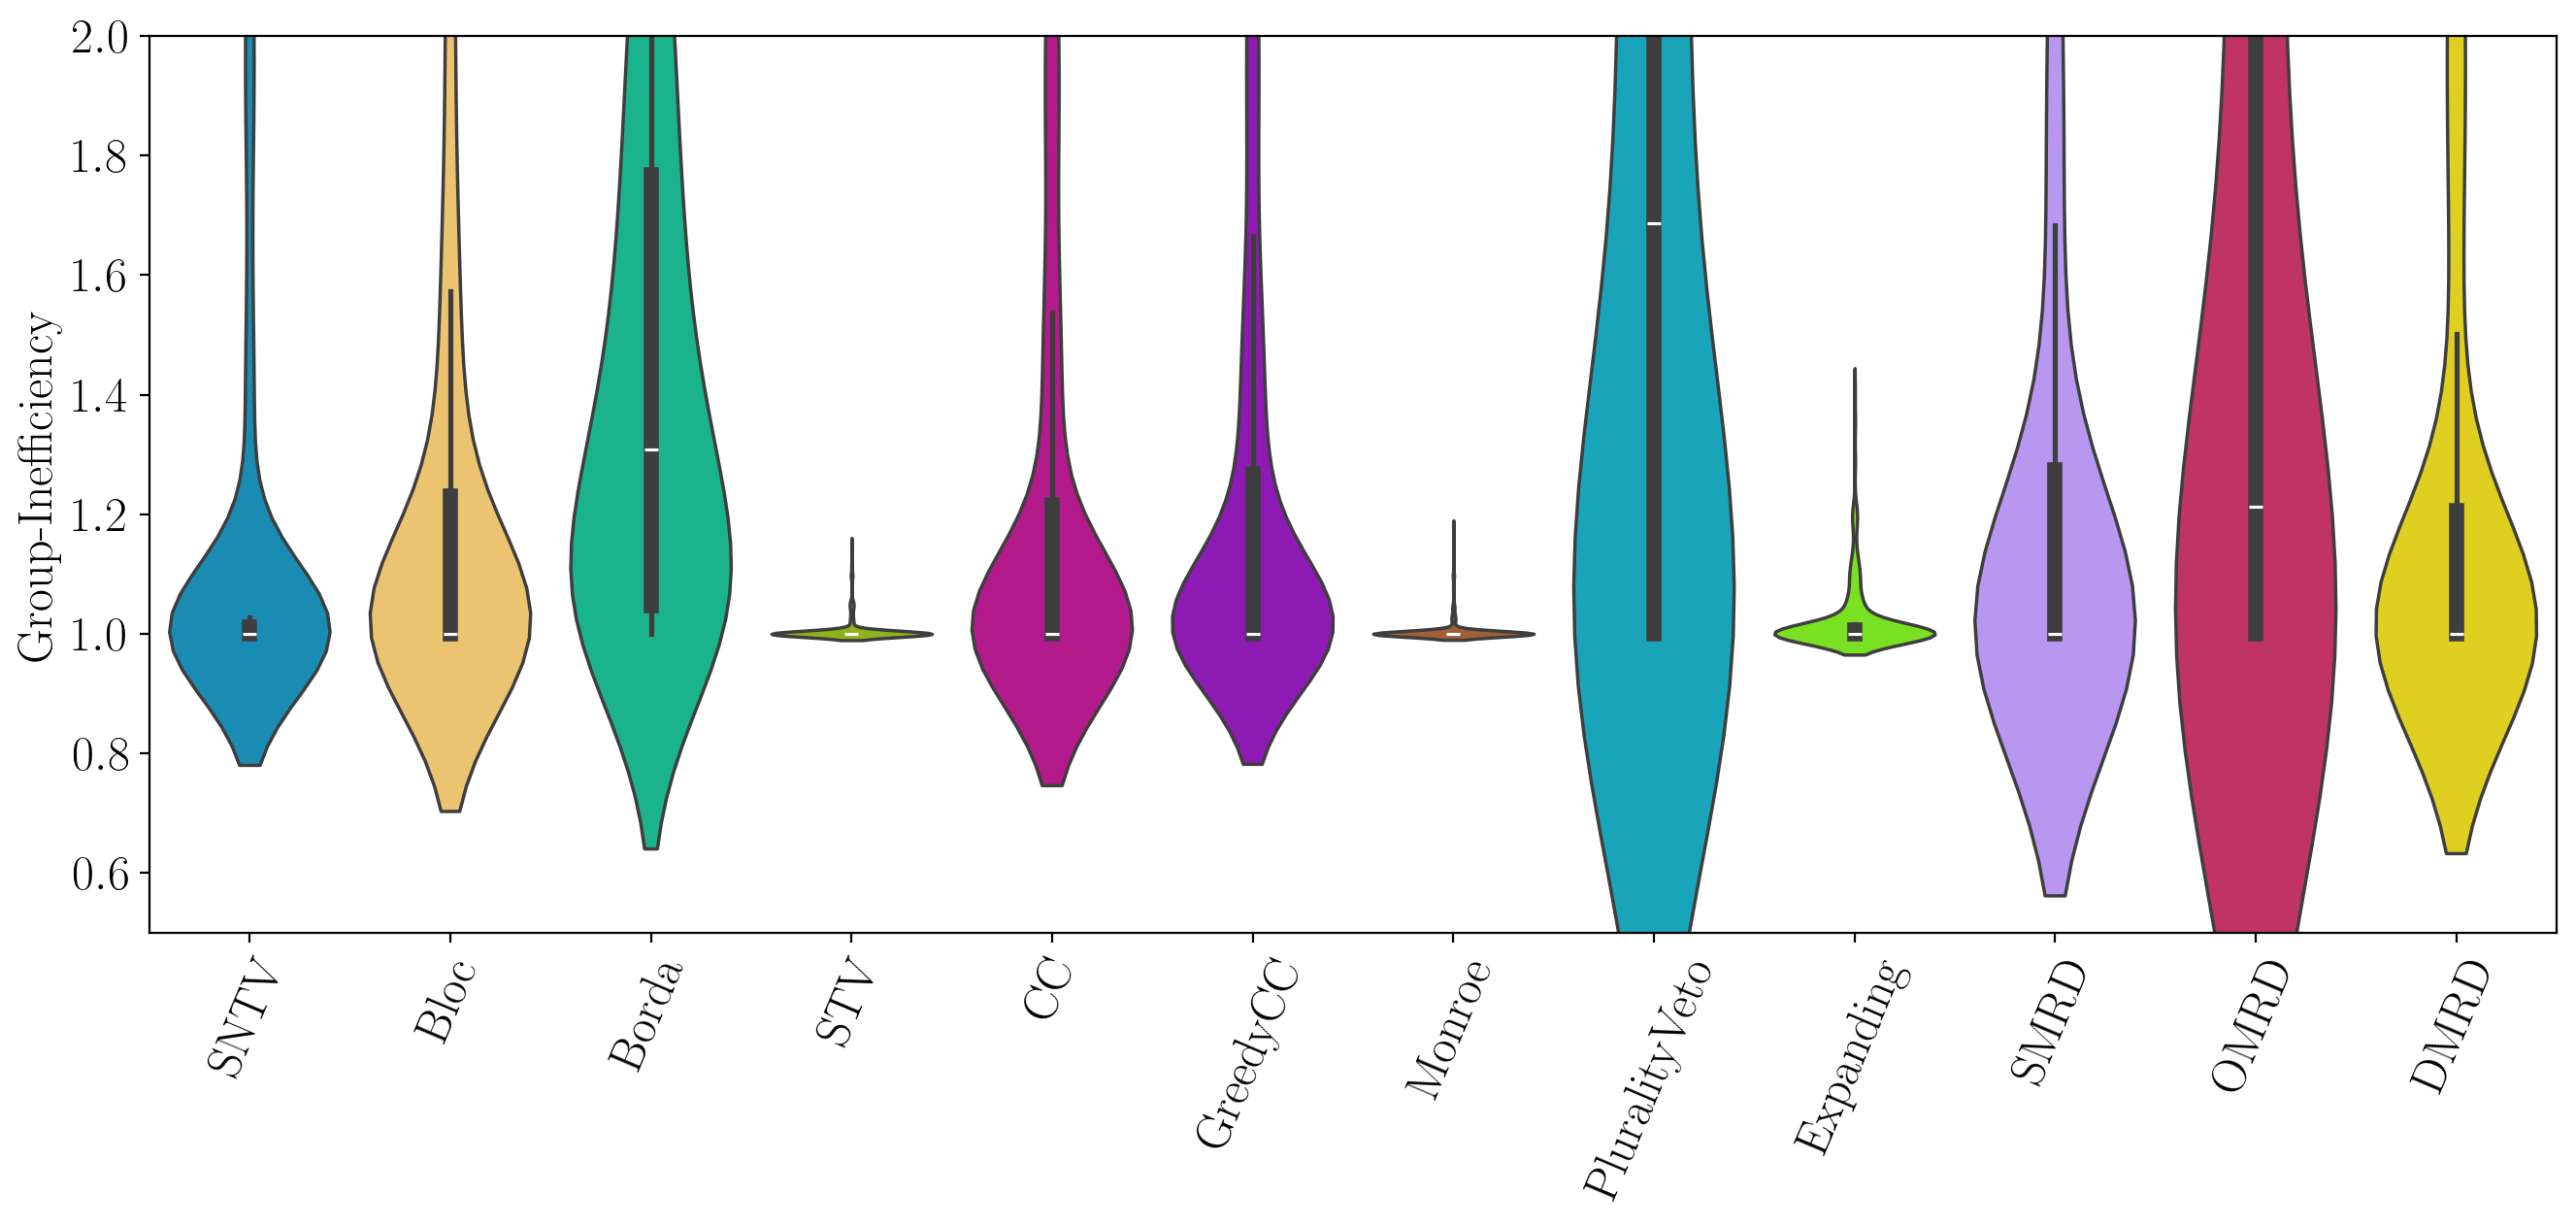

In [32]:
#########################################################################################################################
# Plot Group Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

ax = sns.violinplot(data=group_data.T, palette = colors2, alpha = 1, width = 0.8)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=67)
plt.ylabel('group-inefficiency'.title())
#plt.savefig('../figures/2blocs_100voters/group_ineff.png', dpi = 200, bbox_inches = 'tight')
#####################################################################################################################

Text(0, 0.5, 'Overall-Inefficiency')

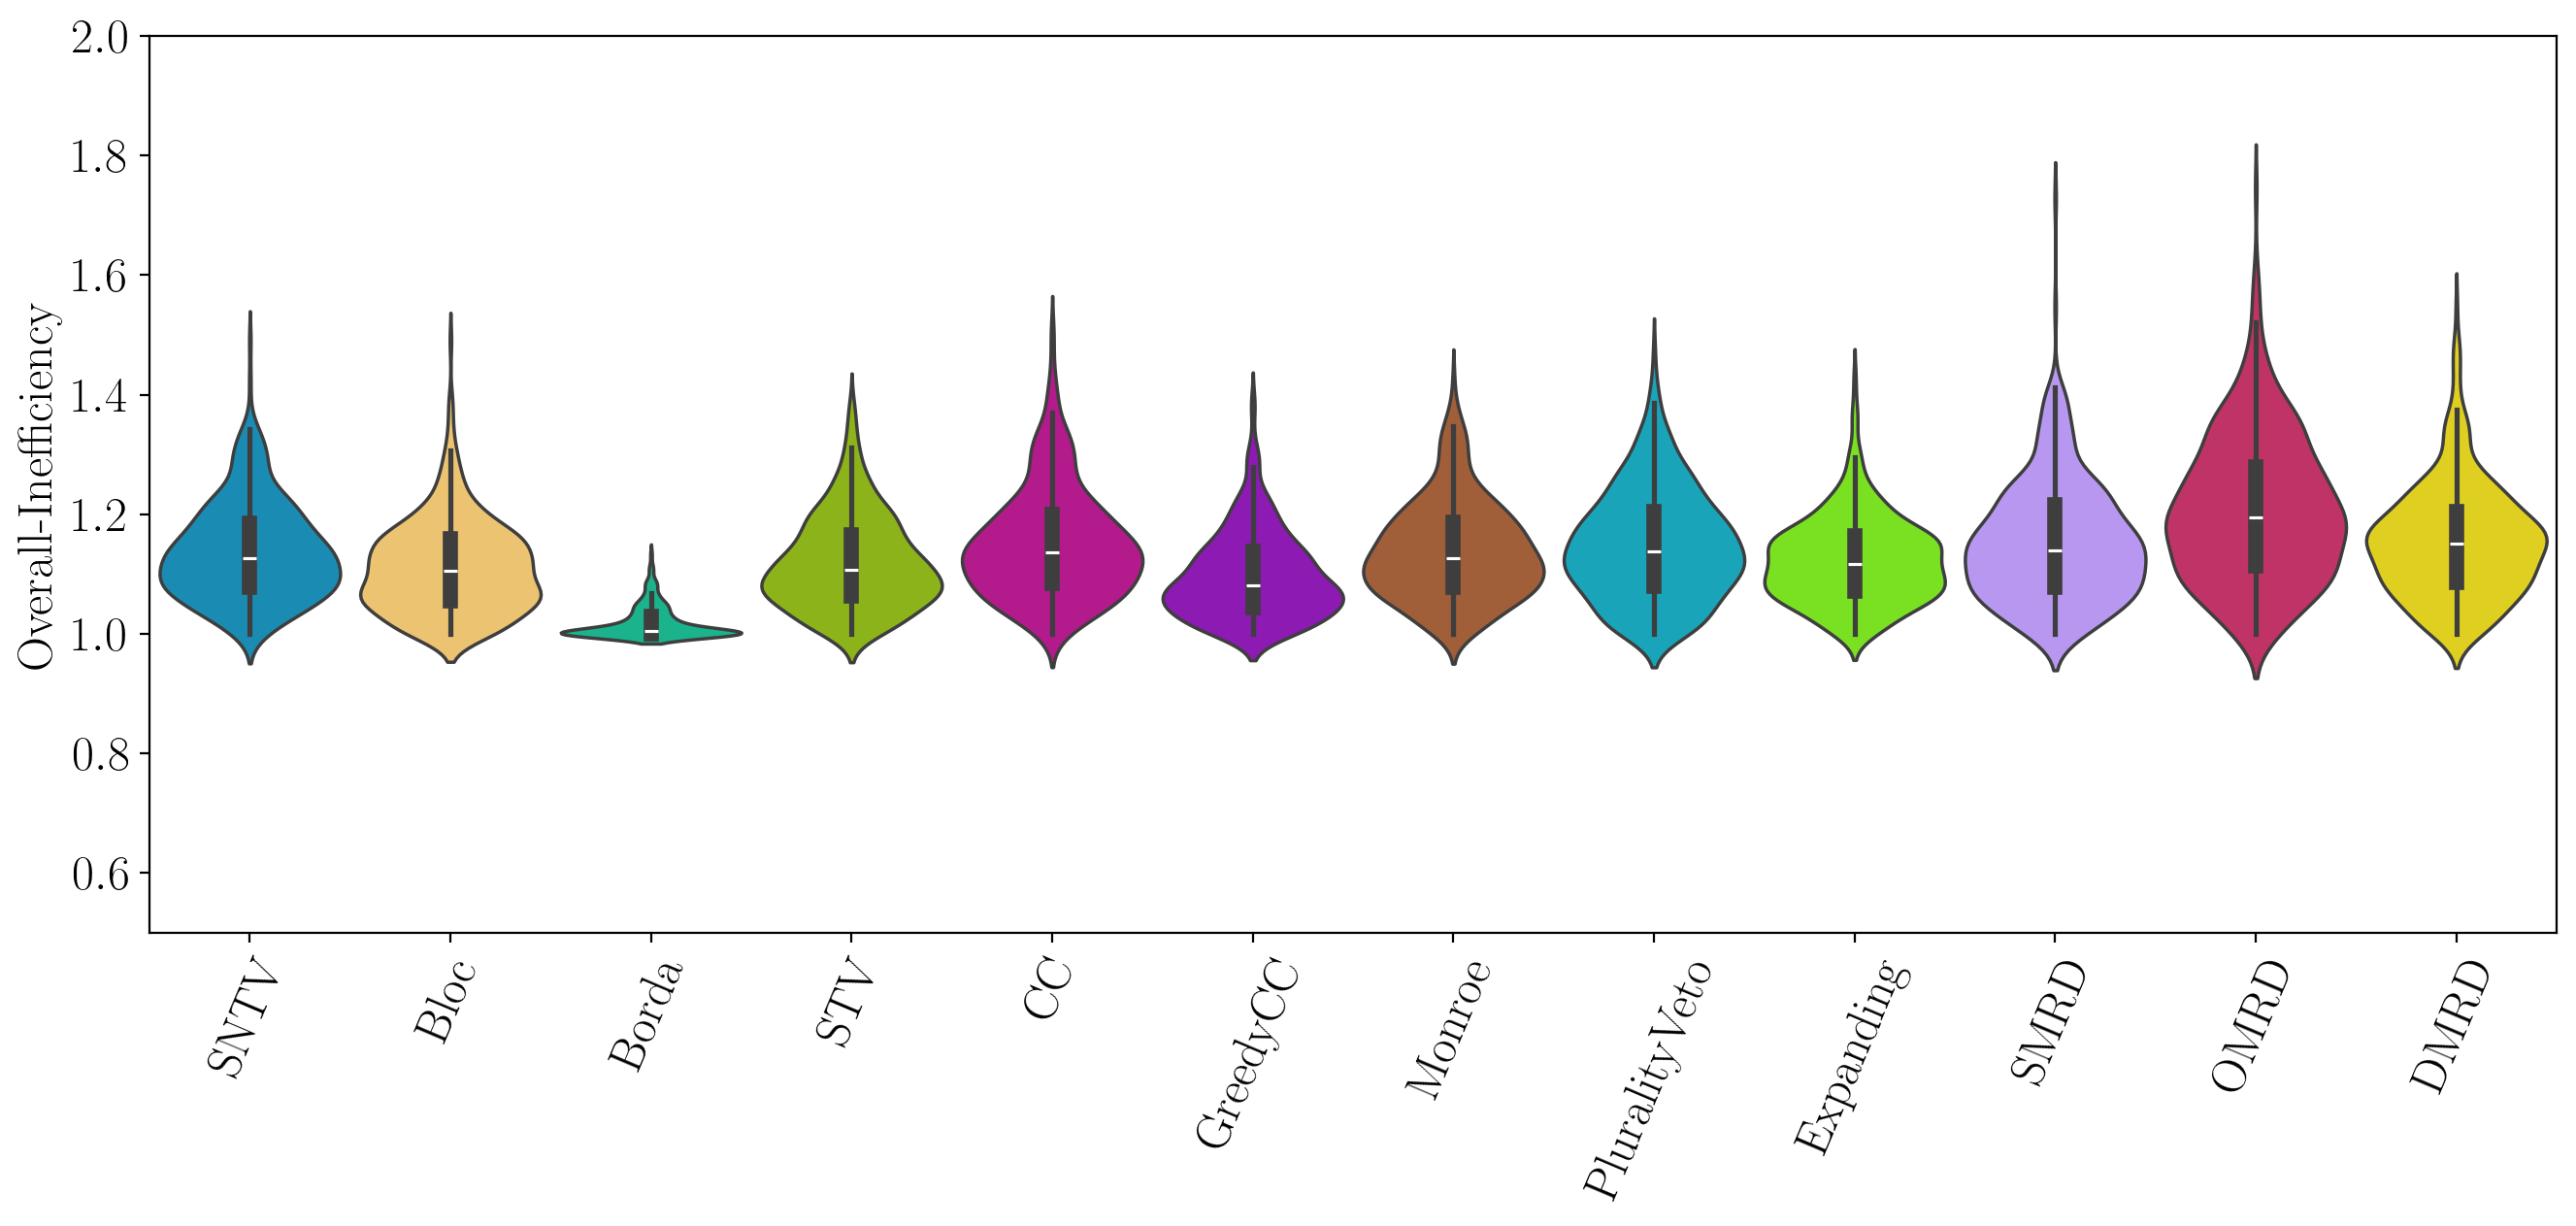

In [33]:
##################################################################################################
# Plot Overall Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

ax = sns.violinplot(data=overall_data.T, palette = colors2, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(0.5, 2)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=67)
plt.ylabel('overall-inefficiency'.title())
#plt.savefig('../figures/2blocs_100voters/overall_ineff.png', dpi = 200, bbox_inches = 'tight')
#################################################################################################33

Text(0, 0.5, '(estimate) worst-group-inefficiency')

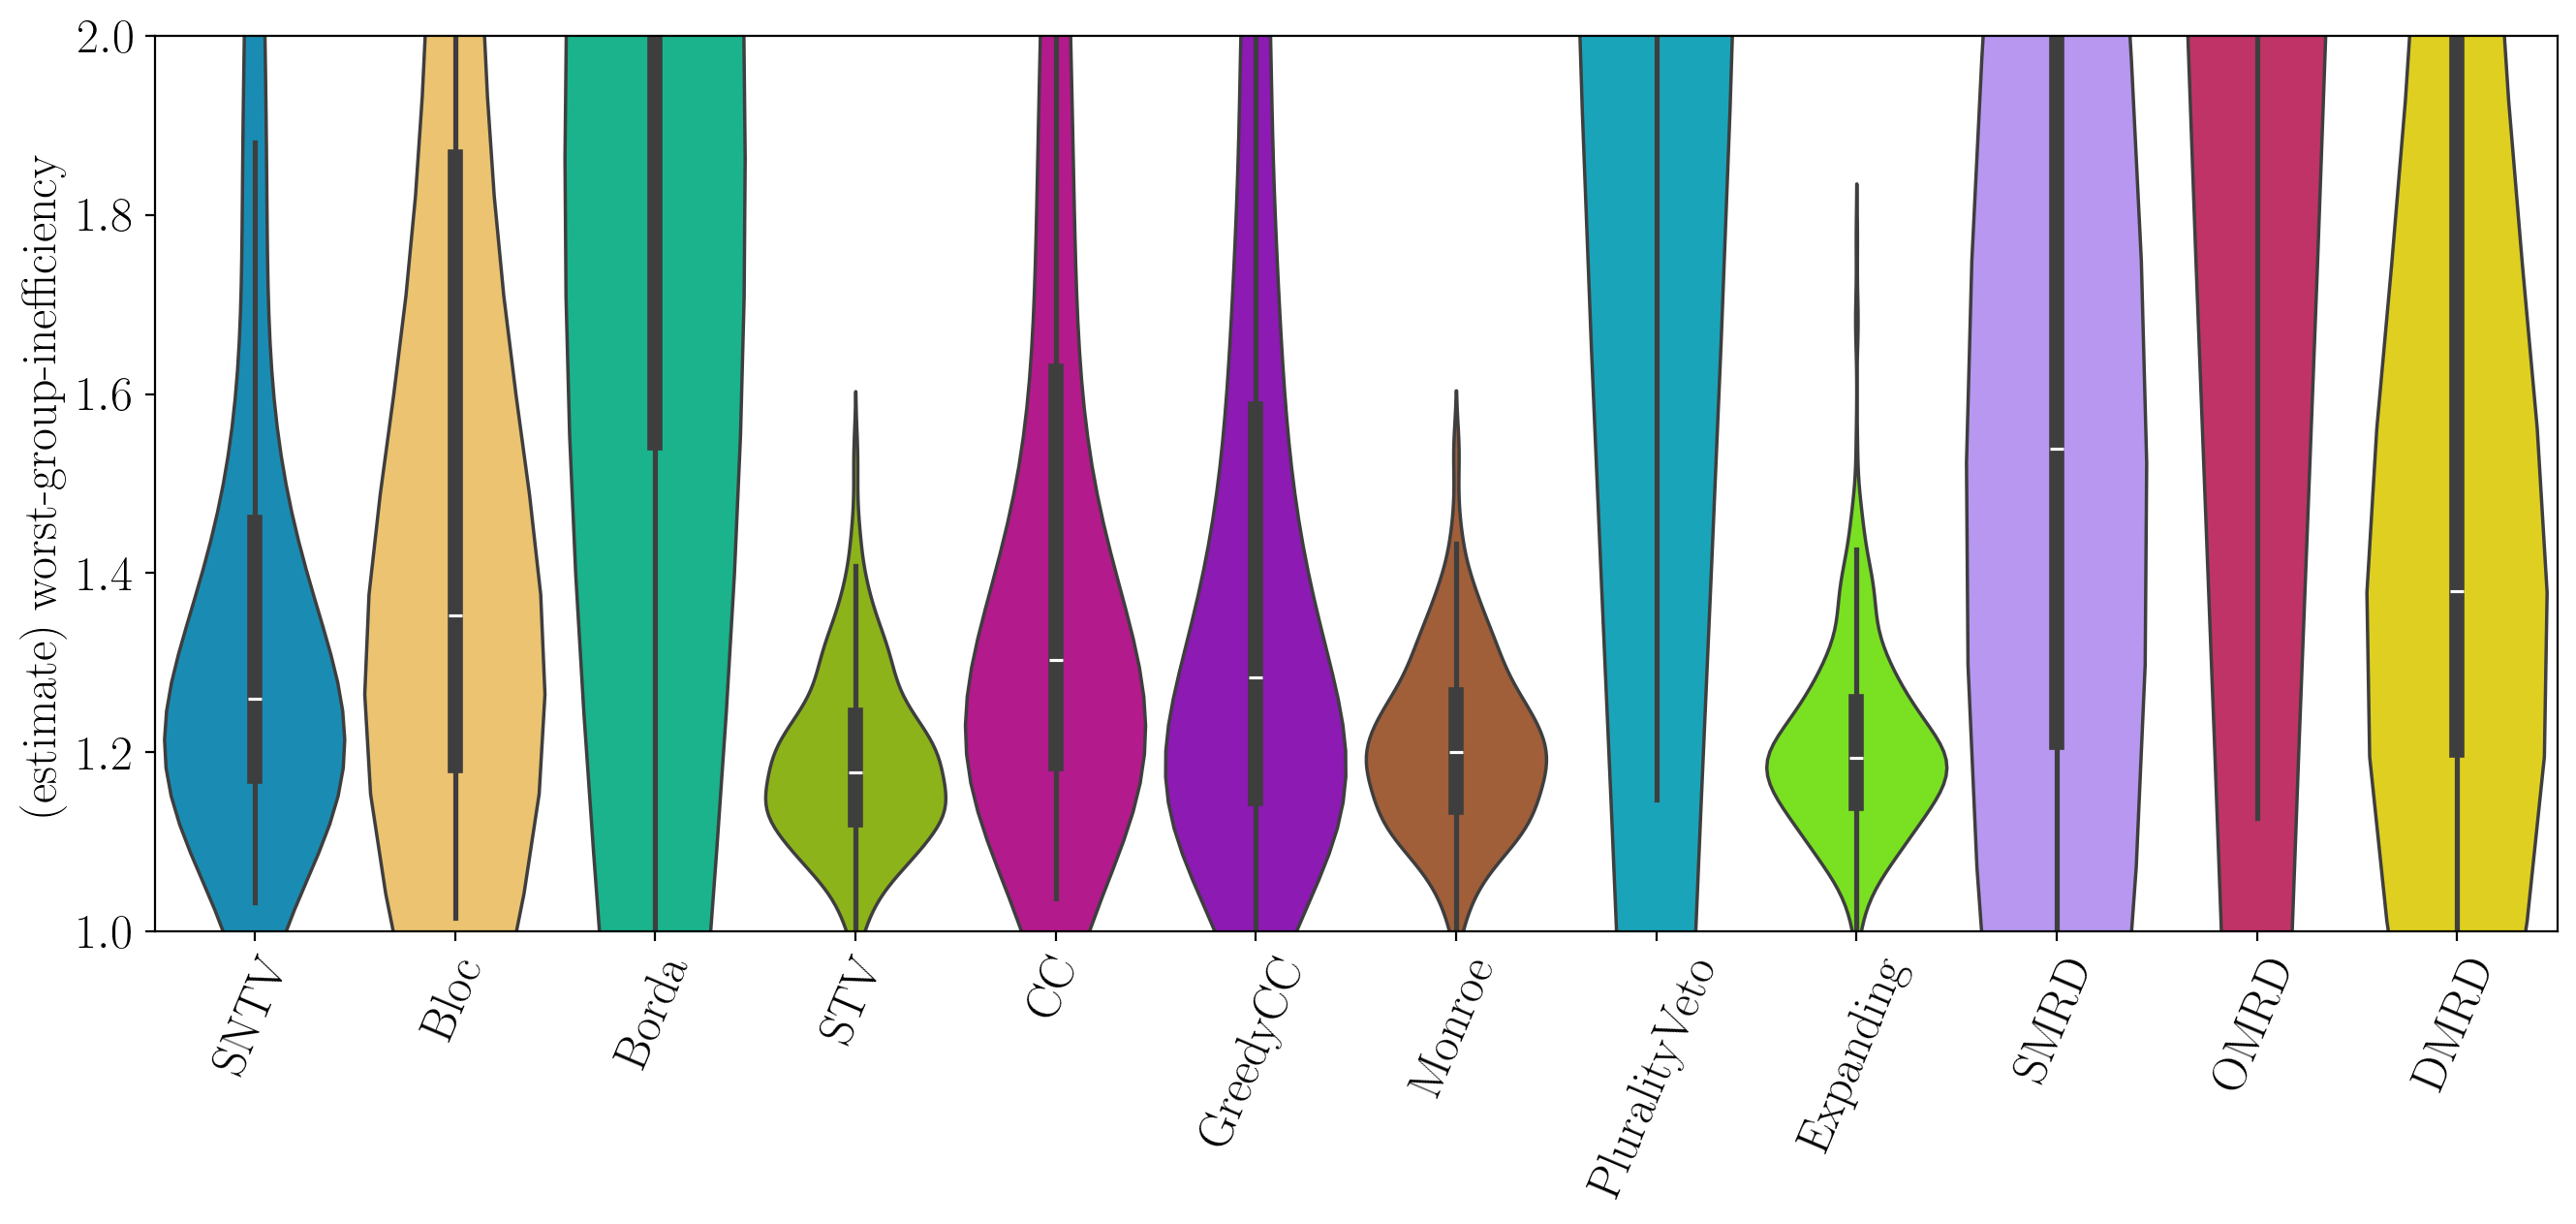

In [34]:
#################################################################################################
# Plot worst Inefficiency Analysis:
plt.figure(figsize=(16, 6), dpi = 200)

ax = sns.violinplot(data=worst_data.T, palette = colors2, alpha = 1, width = 0.9)
for violin in ax.collections:
    violin.set_alpha(1)
    
ax.set_ylim(1, 2)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=67)
plt.ylabel('(estimate) worst-group-inefficiency')

################################################################################################

In [28]:
np.mean(worst_data, axis = 1)

array([0.06462474, 0.07689831, 0.13082031, 0.05464556, 0.06746532,
       0.06537825, 0.05547958, 0.2292024 , 0.05562709, 0.10301461,
       0.25451993, 0.07890044])

### Changing Group Sizes

We were also interested to see when group sizes became unbalanced. Keeping 100 total voters,
we altered the percenatage (from 0 to 100) of the total voters assigned to one of the groups.
The samples for this are precomputed, but the file `experiments/2sizes.py` has all the code needed 
to recompute the data yourself.

In [13]:
# For each size trial, we computed 1,000 samples
n_samples = 10000

In [16]:
group_sizes = [[100 - i, i] for i in range(0, 105, 5)]
bloc_label = 0
num_sizes = len(group_sizes)

elections_dict = {SNTV:{}, Bloc:{}, Borda:{}, STV:{'transfer_type' : 'weighted-fractional'},
                 ChamberlinCourant:{'solver' : 'GUROBI_CMD'}, GreedyCC:{},
                  Monroe:{'solver' : 'GUROBI_CMD'}, 
                  PluralityVeto:{'q' : 2}, ExpandingApprovals: {},
                 SMRD:{}, OMRD:{}, DMRD:{'rho': 0.5}}
elections_list = list(elections_dict.keys())

size_avg_represent = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}
size_avg_represent_overall = {e.__name__:(np.zeros(num_sizes), np.zeros(num_sizes)) for e in elections_list}

for s in range(num_sizes):
    f = '../data/data/2sizes_new' + str(s) + '.npz'
    loaded_data = np.load(f)
    result_dict = {key: loaded_data[key] for key in loaded_data.files}
    
    s_avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
    s_avg_represent_overall = {e.__name__:np.zeros(n_samples) for e in elections_list}
    
    for i in range(n_samples):
        voter_positions = result_dict['voters'][i]
        candidate_positions = result_dict['candidates'][i]
        labels = result_dict['labels'][i]
        labels_overall = np.zeros(len(labels))
        cst_array = euclidean_cost_array(voter_positions, candidate_positions)

        for j,E in enumerate(elections_list):
            name = E.__name__
                
            winners = np.where(result_dict[name][i])[0]
            represent = group_inefficiency(cst_array, winners, labels, bloc_label)
            represent_overall = group_inefficiency(cst_array, winners, labels_overall, bloc_label)
            s_avg_represent[name][i] = represent
            s_avg_represent_overall[name][i] = represent_overall
            
    for ename, evals in s_avg_represent.items():
        size_avg_represent[ename][0][s] = np.mean(evals)
        size_avg_represent[ename][1][s] = np.std(evals)
        
    for ename, evals in s_avg_represent_overall.items():
        size_avg_represent_overall[ename][0][s] = np.mean(evals)
        size_avg_represent_overall[ename][1][s] = np.std(evals)

In [20]:
group_sizes

[[100, 0],
 [95, 5],
 [90, 10],
 [85, 15],
 [80, 20],
 [75, 25],
 [70, 30],
 [65, 35],
 [60, 40],
 [55, 45],
 [50, 50],
 [45, 55],
 [40, 60],
 [35, 65],
 [30, 70],
 [25, 75],
 [20, 80],
 [15, 85],
 [10, 90],
 [5, 95],
 [0, 100]]

In [19]:
Asizes

[1.0,
 0.95,
 0.9,
 0.85,
 0.8,
 0.75,
 0.7,
 0.65,
 0.6,
 0.55,
 0.5,
 0.45,
 0.4,
 0.35,
 0.3,
 0.25,
 0.2,
 0.15,
 0.1,
 0.05,
 0.0]

In [21]:
evals

(array([1.01396291, 1.02059039, 1.05987548, 1.11366117, 1.17183838,
        1.23883288, 1.06495998, 1.10983452, 1.14901081, 1.20218159,
        1.27902064, 1.06544707, 1.11009138, 1.1643146 , 1.24545983,
        1.35359856, 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([0.03090925, 0.10519973, 0.19902742, 0.28394965, 0.34988101,
        0.40618089, 0.27600007, 0.37428648, 0.44327431, 0.51421869,
        0.61906205, 0.49003273, 0.63484965, 0.77959219, 0.95171409,
        1.12384926, 0.        , 0.        , 0.        , 0.        ,
        0.        ]))

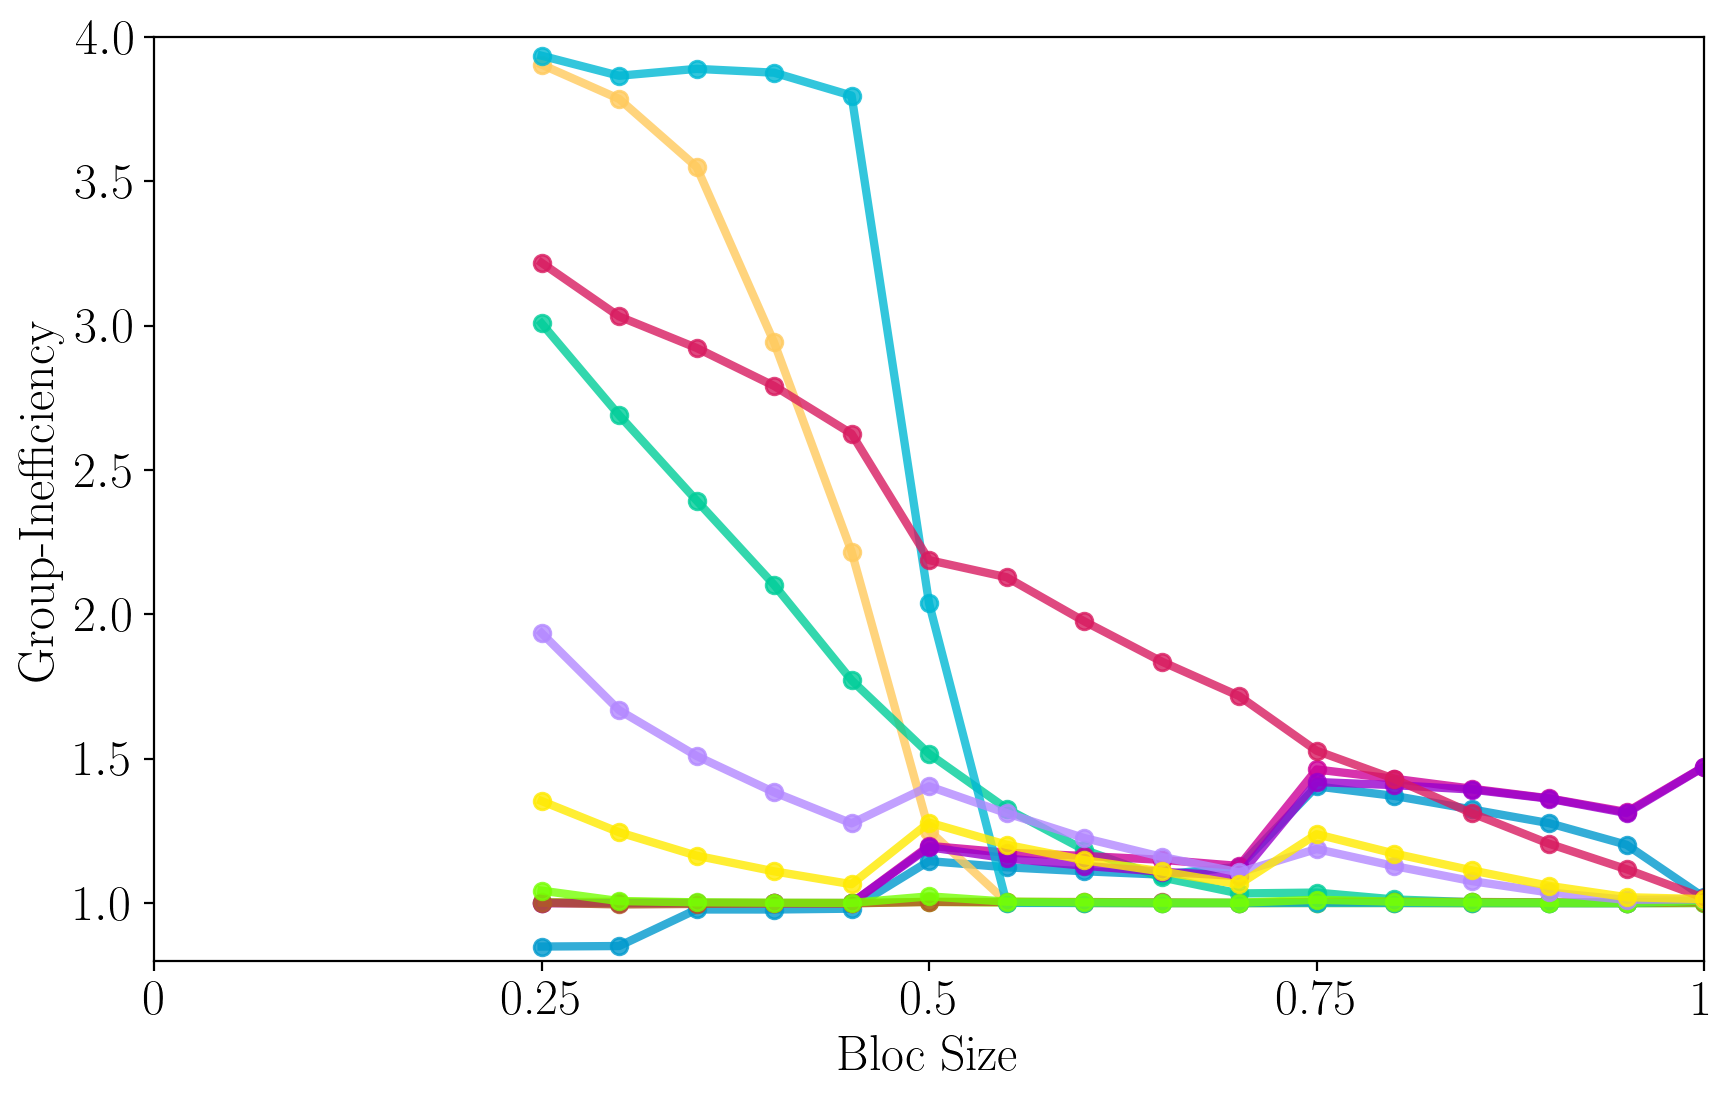

In [28]:
###############################################################################################
# 1) Plot group in-efficiency analysis.
fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [x[group_select]/100 for x in group_sizes][::-1]
for i, (ename,evals) in enumerate(size_avg_represent.items()):
    if name == 'ChamberlinCourant':
        name_label = 'CC'
    elif name == 'ExpandingApprovals':
        name_label = 'Expanding'
    ax.plot(Asizes[5:], evals[0][::-1][5:], label=ename, color = colors2[i], linewidth = 3, marker = 'o', alpha = 0.8)
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)
    

ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
ax.set_ylabel('group-inefficiency'.title())
ax.set_xlabel('Bloc size'.title())
#plt.legend(fontsize = 12, loc = 'upper left')
ax.set_ylim(0.8,4)
plt.savefig('../figures/2blocs_100voters/sizes_group_ineff2.png', dpi = 200, bbox_inches = 'tight')
plt.show()

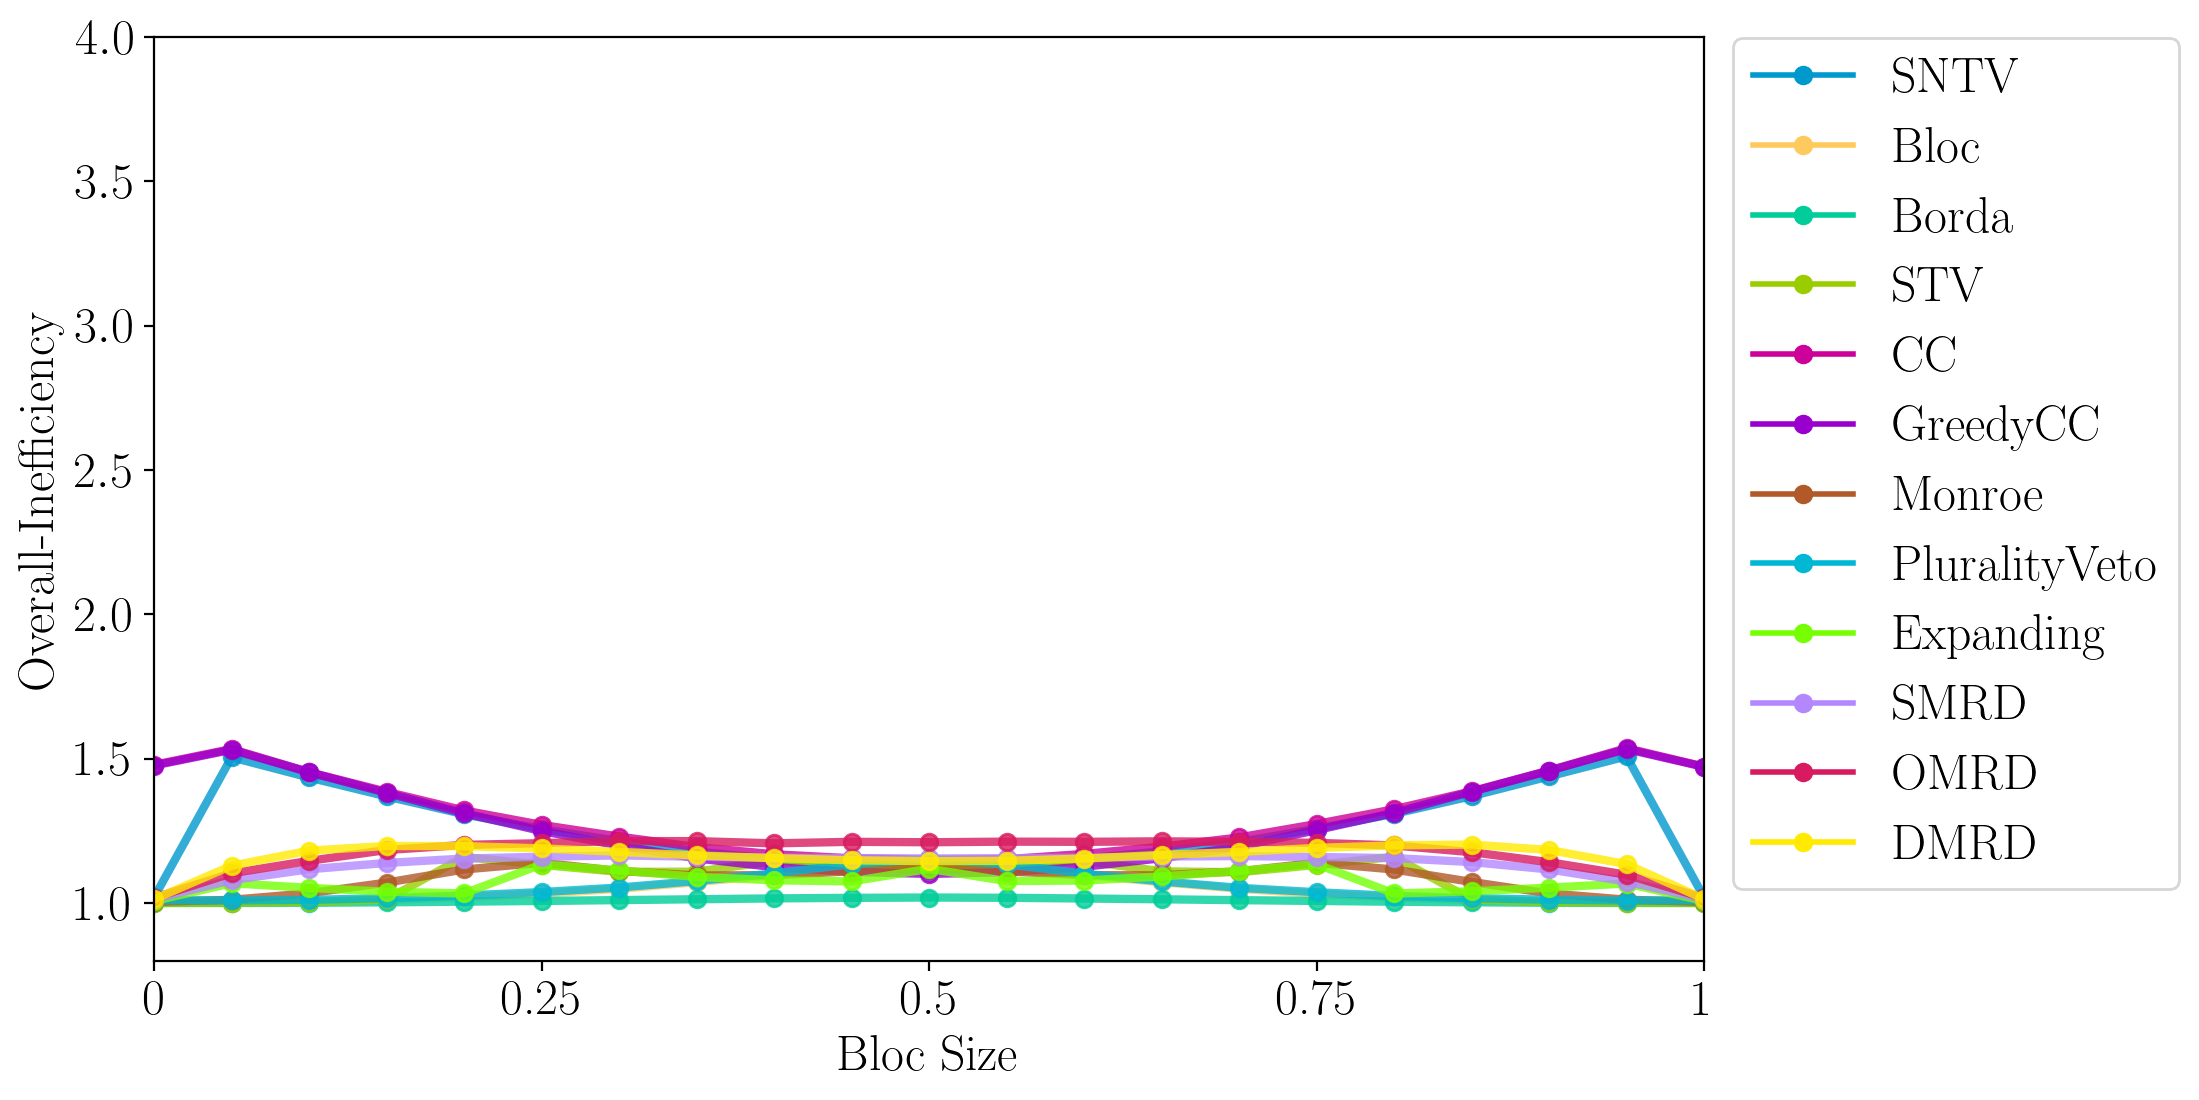

In [29]:
###############################################################################################################
# 2) Plot overall in-efficiency analysis.
fig,ax = plt.subplots(figsize=(10, 6), dpi = 200)

Asizes = [x[group_select]/100 for x in group_sizes][::-1]
for i, (ename,evals) in enumerate(size_avg_represent_overall.items()):
    if name == 'ChamberlinCourant':
        name_label = 'CC'
    elif name == 'ExpandingApprovals':
        name_label = 'Expanding'
    ax.plot(Asizes, evals[0][::-1], label=ename, color = colors2[i], linewidth = 3, marker = 'o', alpha = 0.8)
    #ax.fill_between(Asizes, evals[0] - evals[1], evals[0] + evals[1], color=tab20_colors[i], alpha=0.05)

plt.ylabel('overall-inefficiency'.title())
plt.xlabel('Bloc size'.title())

names = [ename for ename in size_avg_represent_overall.keys()]
names = ['CC' if n == 'ChamberlinCourant' else n for n in names]
names = ['Expanding' if n == 'ExpandingApprovals' else n for n in names]
legend_elements = [Line2D([0], [0], marker = 'o', color=colors2[i], lw=2, label=names[i]) for i in range(len(names))]


ax.set_xlim(0, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'])
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 0.9), ncol=1)
ax.set_ylim(0.8,4)
plt.savefig('../figures/2blocs_100voters/sizes_overall_ineff2.png', dpi = 200, bbox_inches = 'tight')
plt.show()